In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor
from optuna.samplers import TPESampler
import optuna

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


In [4]:
# Importing Data
train = pd.read_csv('/kaggle/input/playground-series-s4e5/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e5/test.csv')

In [6]:
# Displaying First Few Rows of Test Data
test.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
0,1117957,4,6,3,5,6,7,8,7,8,...,8,5,7,5,6,3,6,4,4,5
1,1117958,4,4,2,9,5,5,4,7,5,...,2,4,7,4,5,1,7,4,4,3
2,1117959,1,3,6,5,7,2,4,6,4,...,7,9,2,5,5,2,3,6,8,3
3,1117960,2,4,4,6,4,5,4,3,4,...,7,8,4,6,7,6,4,2,4,4
4,1117961,6,3,2,4,6,4,5,5,3,...,4,3,2,6,4,6,8,4,5,5


In [5]:
# Displaying First Few Rows of Train Data
train.head()

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,...,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,...,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,...,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,...,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


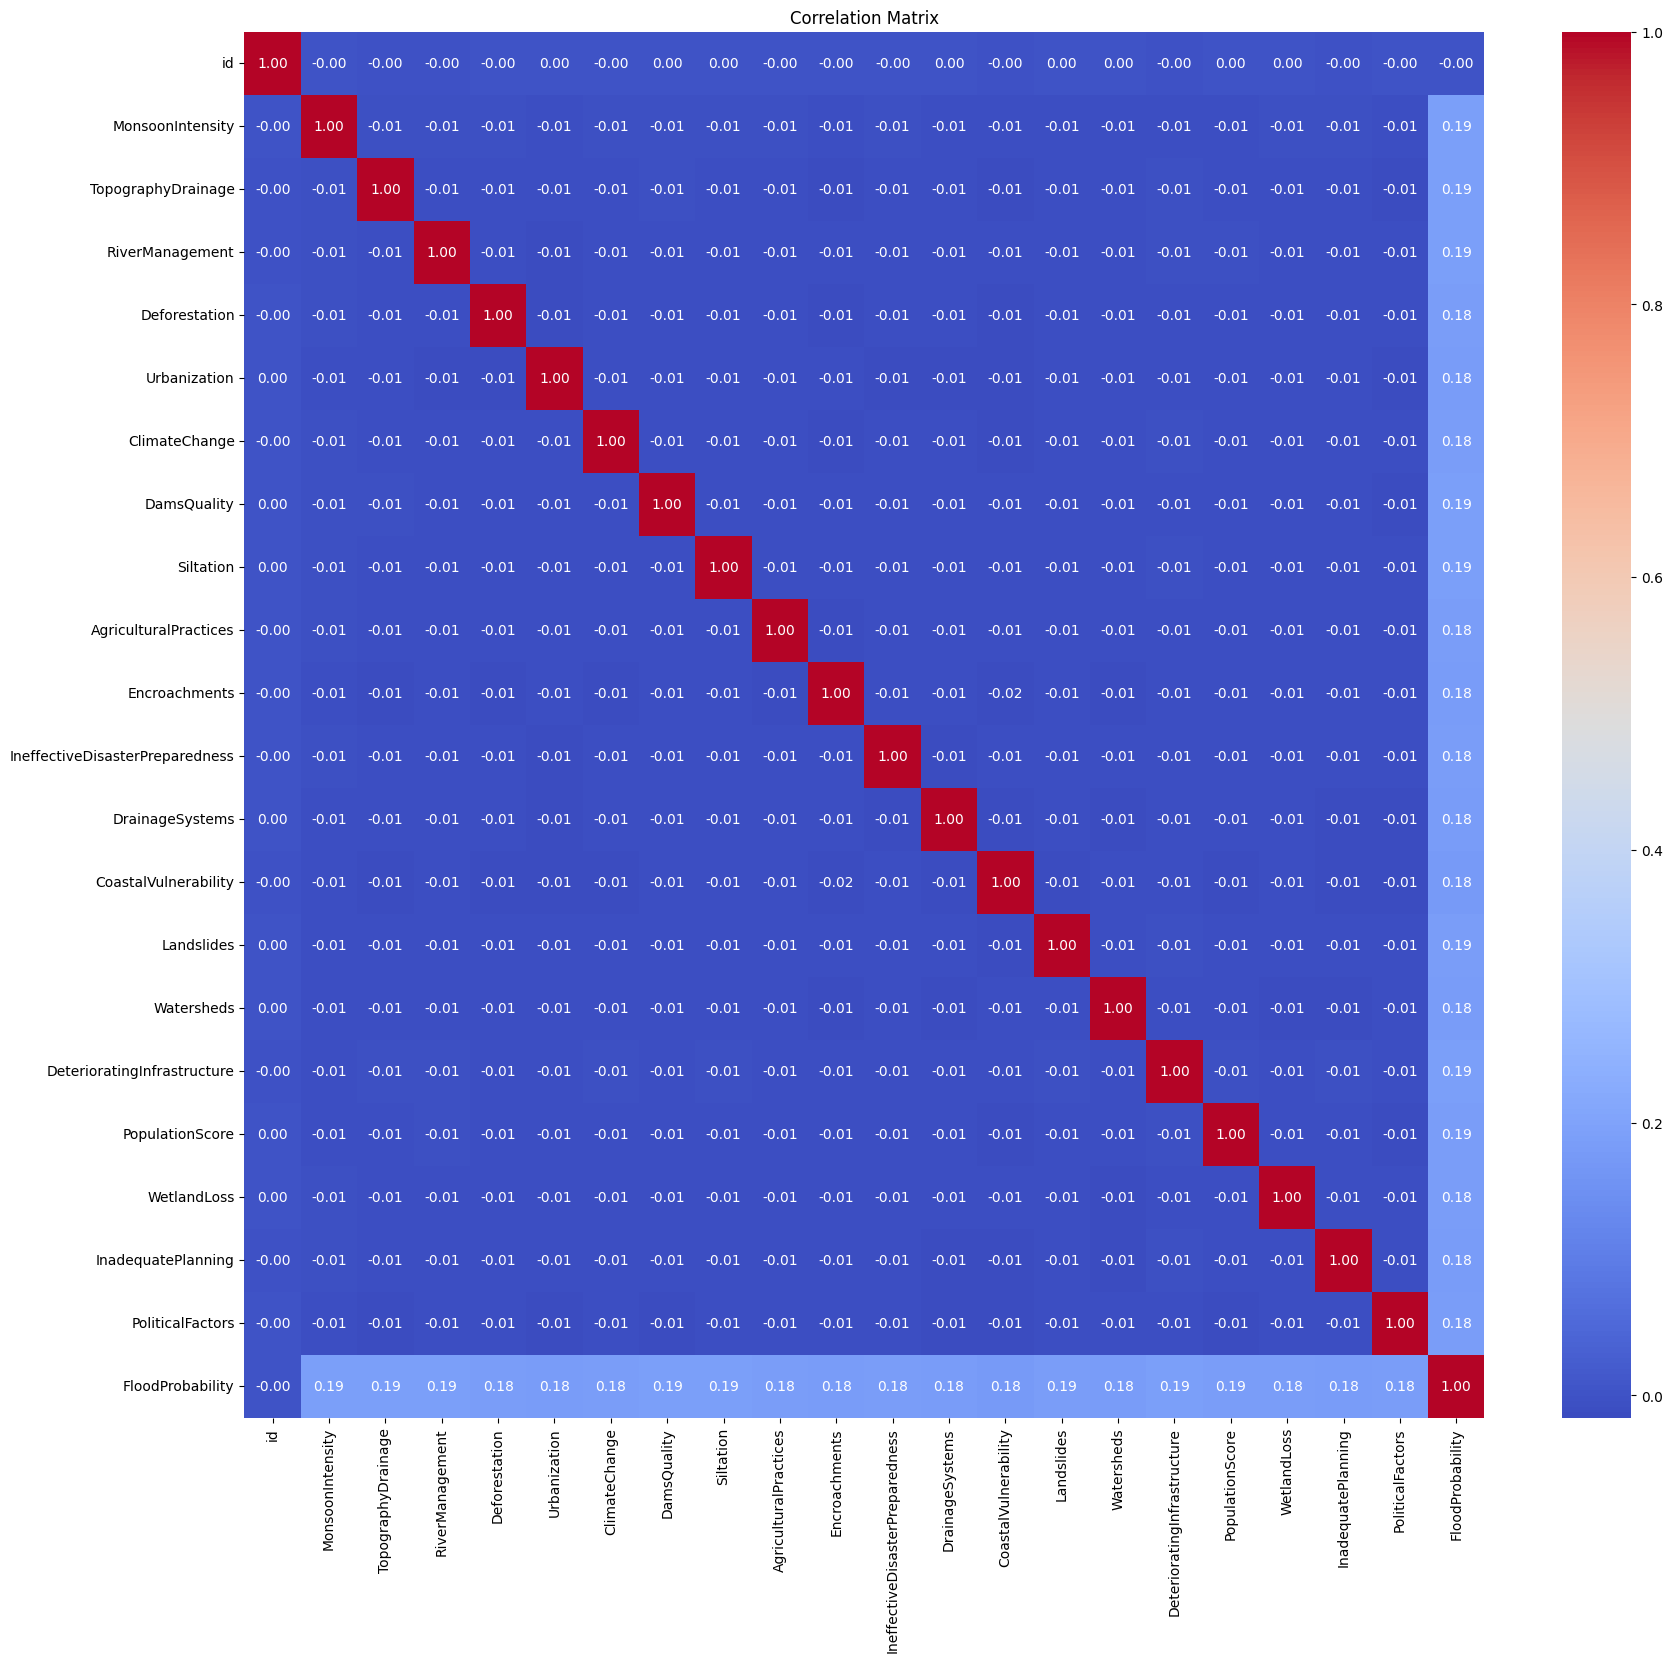

In [7]:
# Exploring Correlation Matrix
correlation_matrix = train.corr()
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

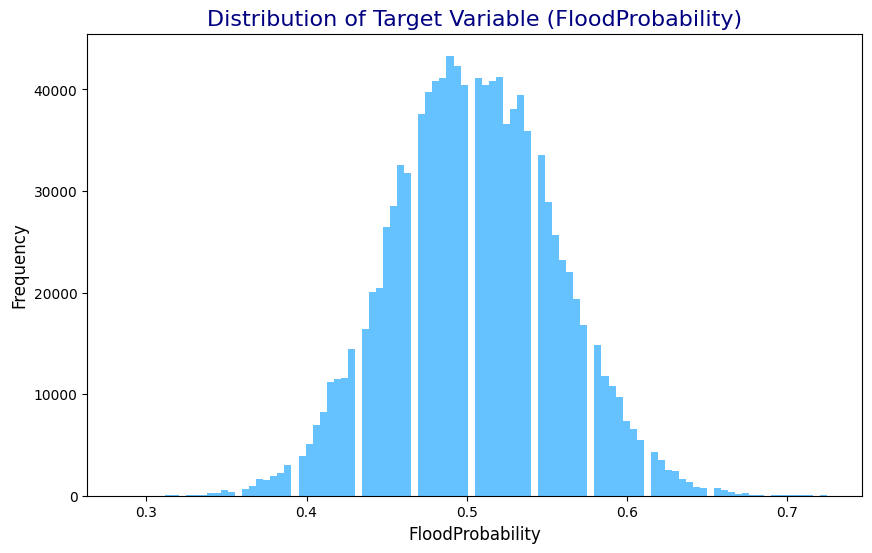

In [8]:
# Custom color for the histogram
hist_color = "#66c2ff"  # Light blue

# Visualizing Distribution of Target Variable with Custom Color
plt.figure(figsize=(10, 6))
plt.hist(train.FloodProbability, bins=100, color=hist_color)
plt.title("Distribution of Target Variable (FloodProbability)", fontsize=16, color='navy')
plt.xlabel("FloodProbability", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()


In [11]:
# Defining Features and Non-Features
NON_FEATURES = ['id', 'FloodProbability', 'fold']
BASE_FEATURES = ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors']

# Adding Derived Features
def add_features(df):
    df['total'] = df[BASE_FEATURES].sum(axis=1)
    df['amplified_sum'] = (df[BASE_FEATURES] ** 1.5).sum(axis=1)
    df['fskew'] = df[BASE_FEATURES].skew(axis=1)
    df['fkurtosis'] = df[BASE_FEATURES].kurtosis(axis=1)
    df['mean'] = df[BASE_FEATURES].mean(axis=1)
    df['std'] = df[BASE_FEATURES].std(axis=1)
    df['max'] = df[BASE_FEATURES].max(axis=1)
    df['min'] = df[BASE_FEATURES].min(axis=1)
    df['range'] = df['max'] - df['min']
    df['median'] = df[BASE_FEATURES].median(axis=1)
    df['ptp'] = df[BASE_FEATURES].values.ptp(axis=1)
    df['q25'] = df[BASE_FEATURES].quantile(0.25, axis=1)
    df['q75'] = df[BASE_FEATURES].quantile(0.75, axis=1)
    return df

In [12]:
# Applying Feature Engineering to Train and Test Data
train = add_features(train)

# Defining Final Feature Set
FEATURES = [col for col in train.columns if col not in NON_FEATURES]
train = train[['id'] + FEATURES + ['FloodProbability']]
test = add_features(test)
X_test = test[FEATURES]

# Separating Features and Target Variable
X_train = train.drop(['id', 'FloodProbability'], axis=1)
y_train = train['FloodProbability']

# Scaling Features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# Cross-Validation Setup
cv = KFold(5, shuffle=True, random_state=0)
cv_splits = cv.split(X_train, y_train)
scores = list()

# Model Training and Evaluation
model = LGBMRegressor(objective='regression', random_state=0,)
for train_idx, val_idx in cv_splits:
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    r2 = r2_score(y_val_fold, y_pred)
    scores.append(r2)
    
print(f'Mean R2 score: {np.mean(scores):.5f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.747269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1615
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 33
[LightGBM] [Info] Start training from score 0.504476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.699400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1623
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 33
[LightGBM] [Info] Start training from score 0.504489
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.781194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1623
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 33
[LightGBM] [Info] Start 

In [19]:
print(train.columns)


Index(['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'total', 'amplified_sum',
       'fskew', 'fkurtosis', 'mean', 'std', 'max', 'min', 'range', 'median',
       'ptp', 'q25', 'q75', 'FloodProbability'],
      dtype='object')


In [ ]:
optimize = False

def objective(trial):
    # Define Hyperparameters to be Optimized
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 15)
    }
    # Cross-Validation Setup
    cv = KFold(5, shuffle=True, random_state=0)
    cv_splits = cv.split(X_train, y_train)
    scores = list()
    model = LGBMRegressor(**params, objective='regression', random_state=0, device='gpu', verbosity=-1)
    for train_idx, val_idx in cv_splits:
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        
        model.fit(X_train_fold, y_train_fold)
        
        y_pred = model.predict(X_val_fold)
        r2 = r2_score(y_val_fold, y_pred)
        scores.append(r2)
        
    return np.mean(scores)

# Hyperparameter Optimization
if optimize:
    sqlite_db = "sqlite:///lgbm.db"
    study_name = "lgbm"
    study = optuna.create_study(storage=sqlite_db, study_name=study_name, 
                                sampler=TPESampler(n_startup_trials=75, multivariate=True, seed=0),
                                direction="maximize", load_if_exists=True)

    study.optimize(objective, n_trials=200)
    print(f"best optimized R2: {study.best_value:0.5f}")
    print(f"best hyperparameters: {study.best_params}")
else: 
    # Default Hyperparameters
    lgbm_params = {
        'num_leaves': 249, 
        'learning_rate': 0.015257139375608821, 
        'n_estimators': 546, 
        'subsample_for_bin': 298999, 
        'min_child_samples': 77, 
        'reg_alpha': 2.7240879929233532e-05, 
        'reg_lambda': 9.693029775370852e-10, 
        'colsample_bytree': 0.8107657422421071, 
        'subsample': 0.8727733774586144, 
        'max_depth': 10,
    }

# Model Training with Optimized Hyperparameters
cv = KFold(5, shuffle=True, random_state=0)
cv_splits = cv.split(X_train, y_train)
scores = list()
test_preds = list()
model = LGBMRegressor(**lgbm_params, objective='regression', random_state=0, device='gpu', verbosity=-1)
for train_idx, val_idx in cv_splits:
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    model.fit(X_train_fold, y_train_fold)
    y_val_pred = model.predict(X_val_fold)
    r2 = r2_score(y_val_fold, y_val_pred)
    scores.append(r2)
    y_pred = model.predict(X_test)
    test_preds.append(y_pred)

print(f'Mean R2 score: {np.mean(scores):.5f}')

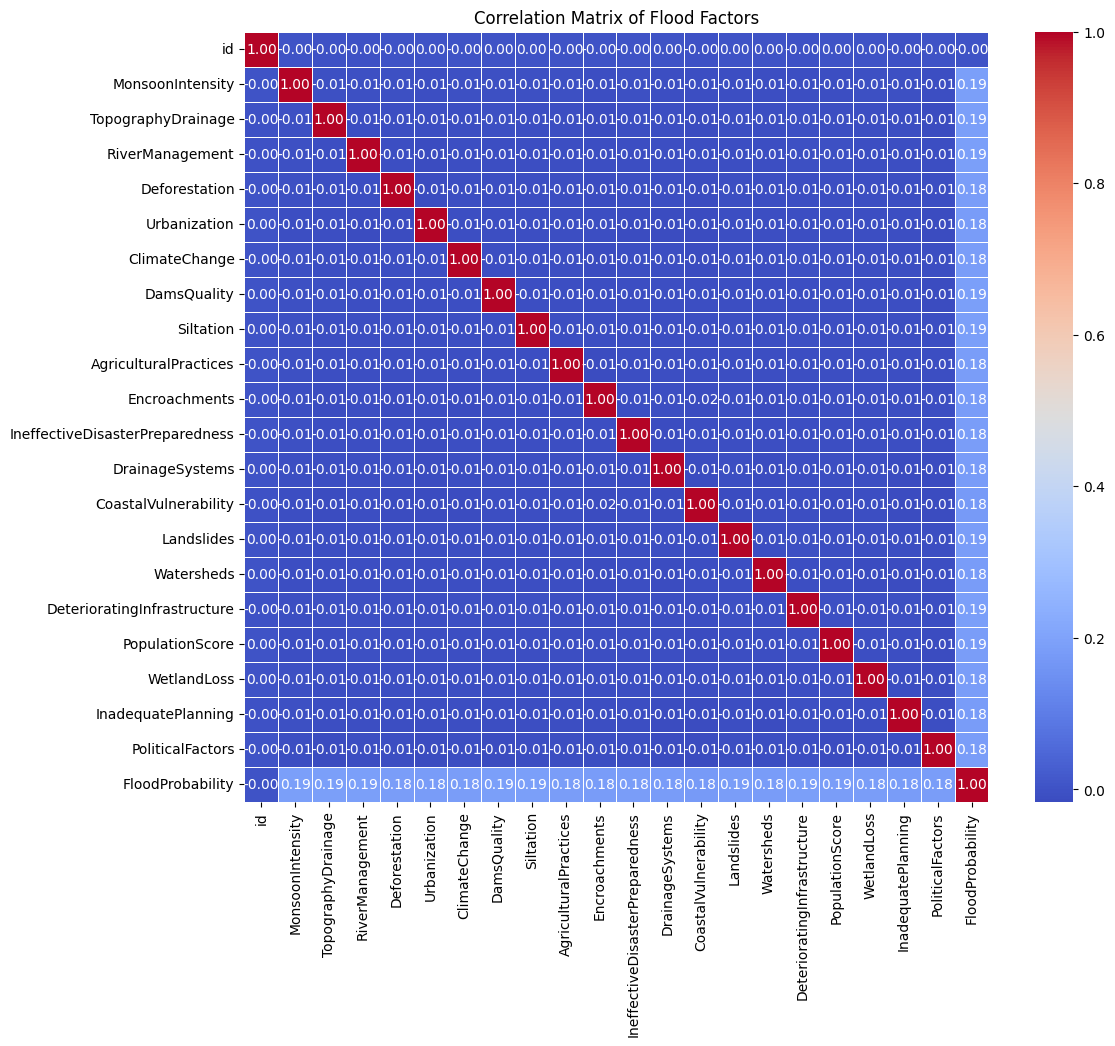

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the correlation matrix
corr = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Flood Factors')
plt.show()

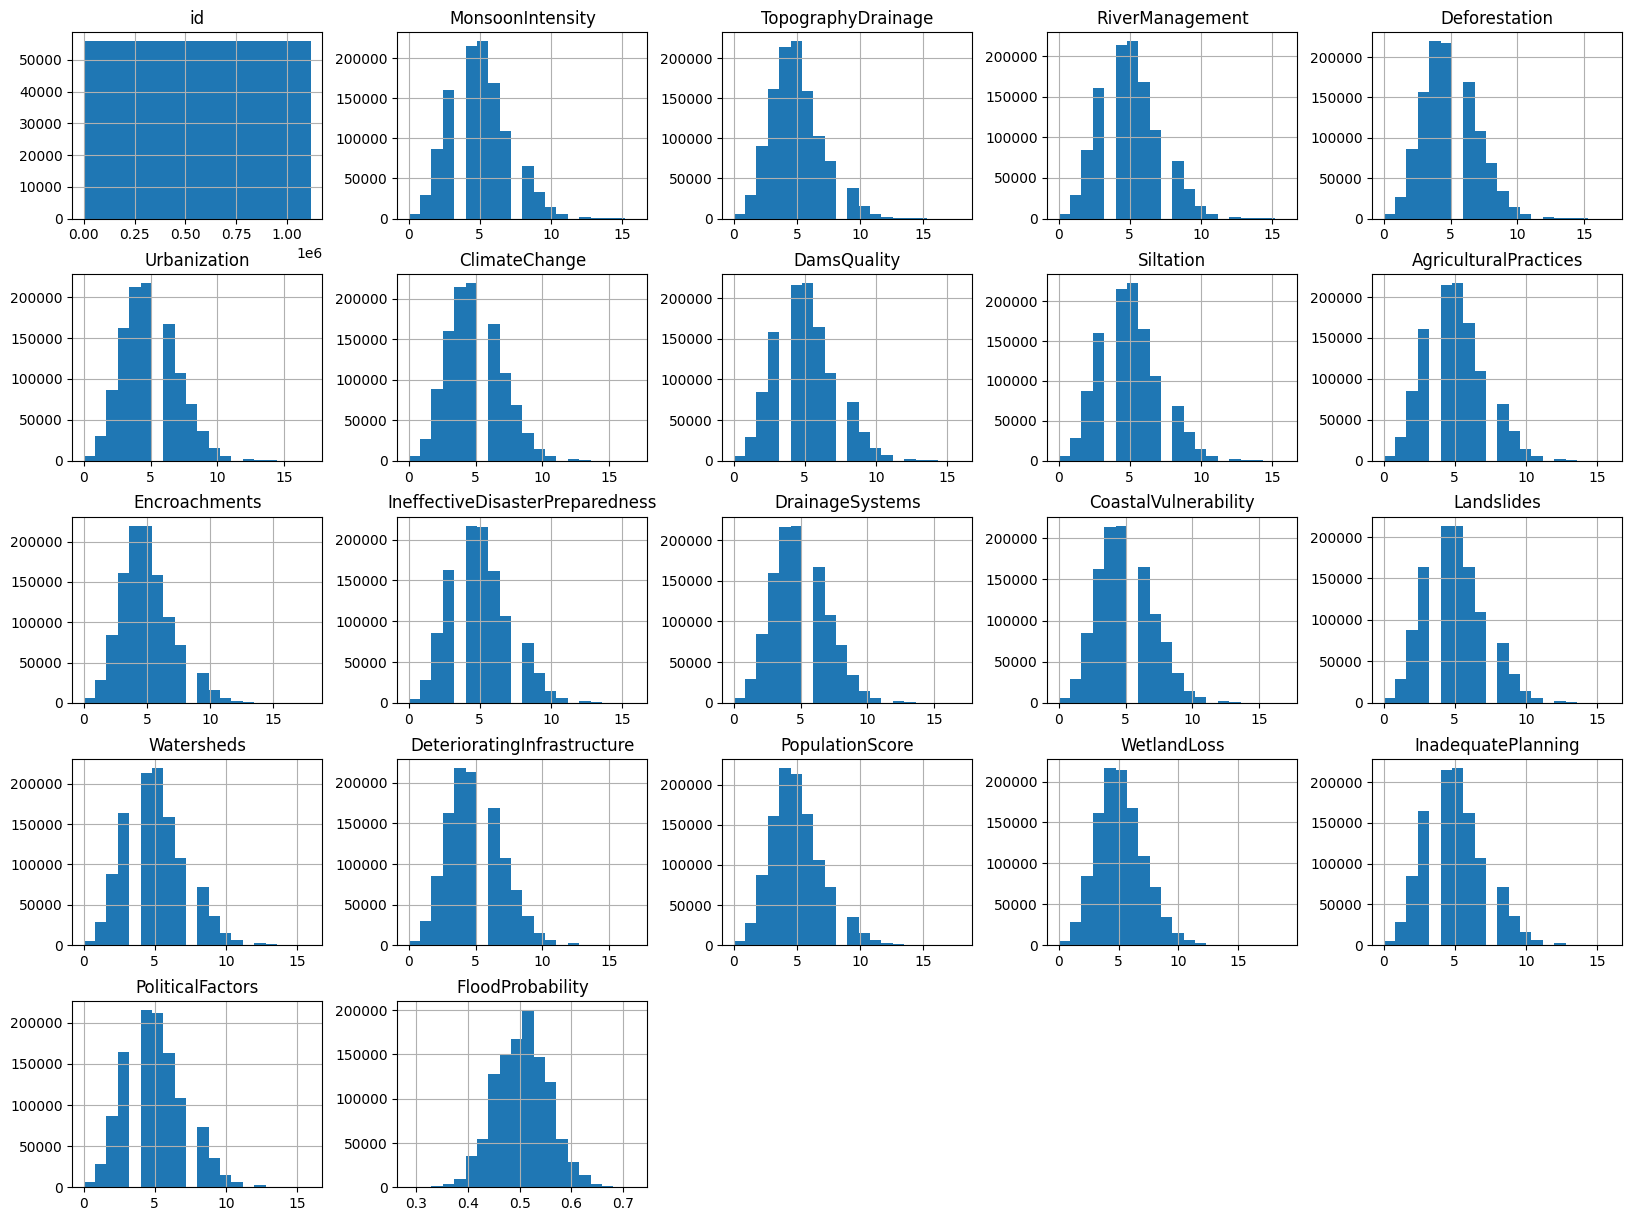

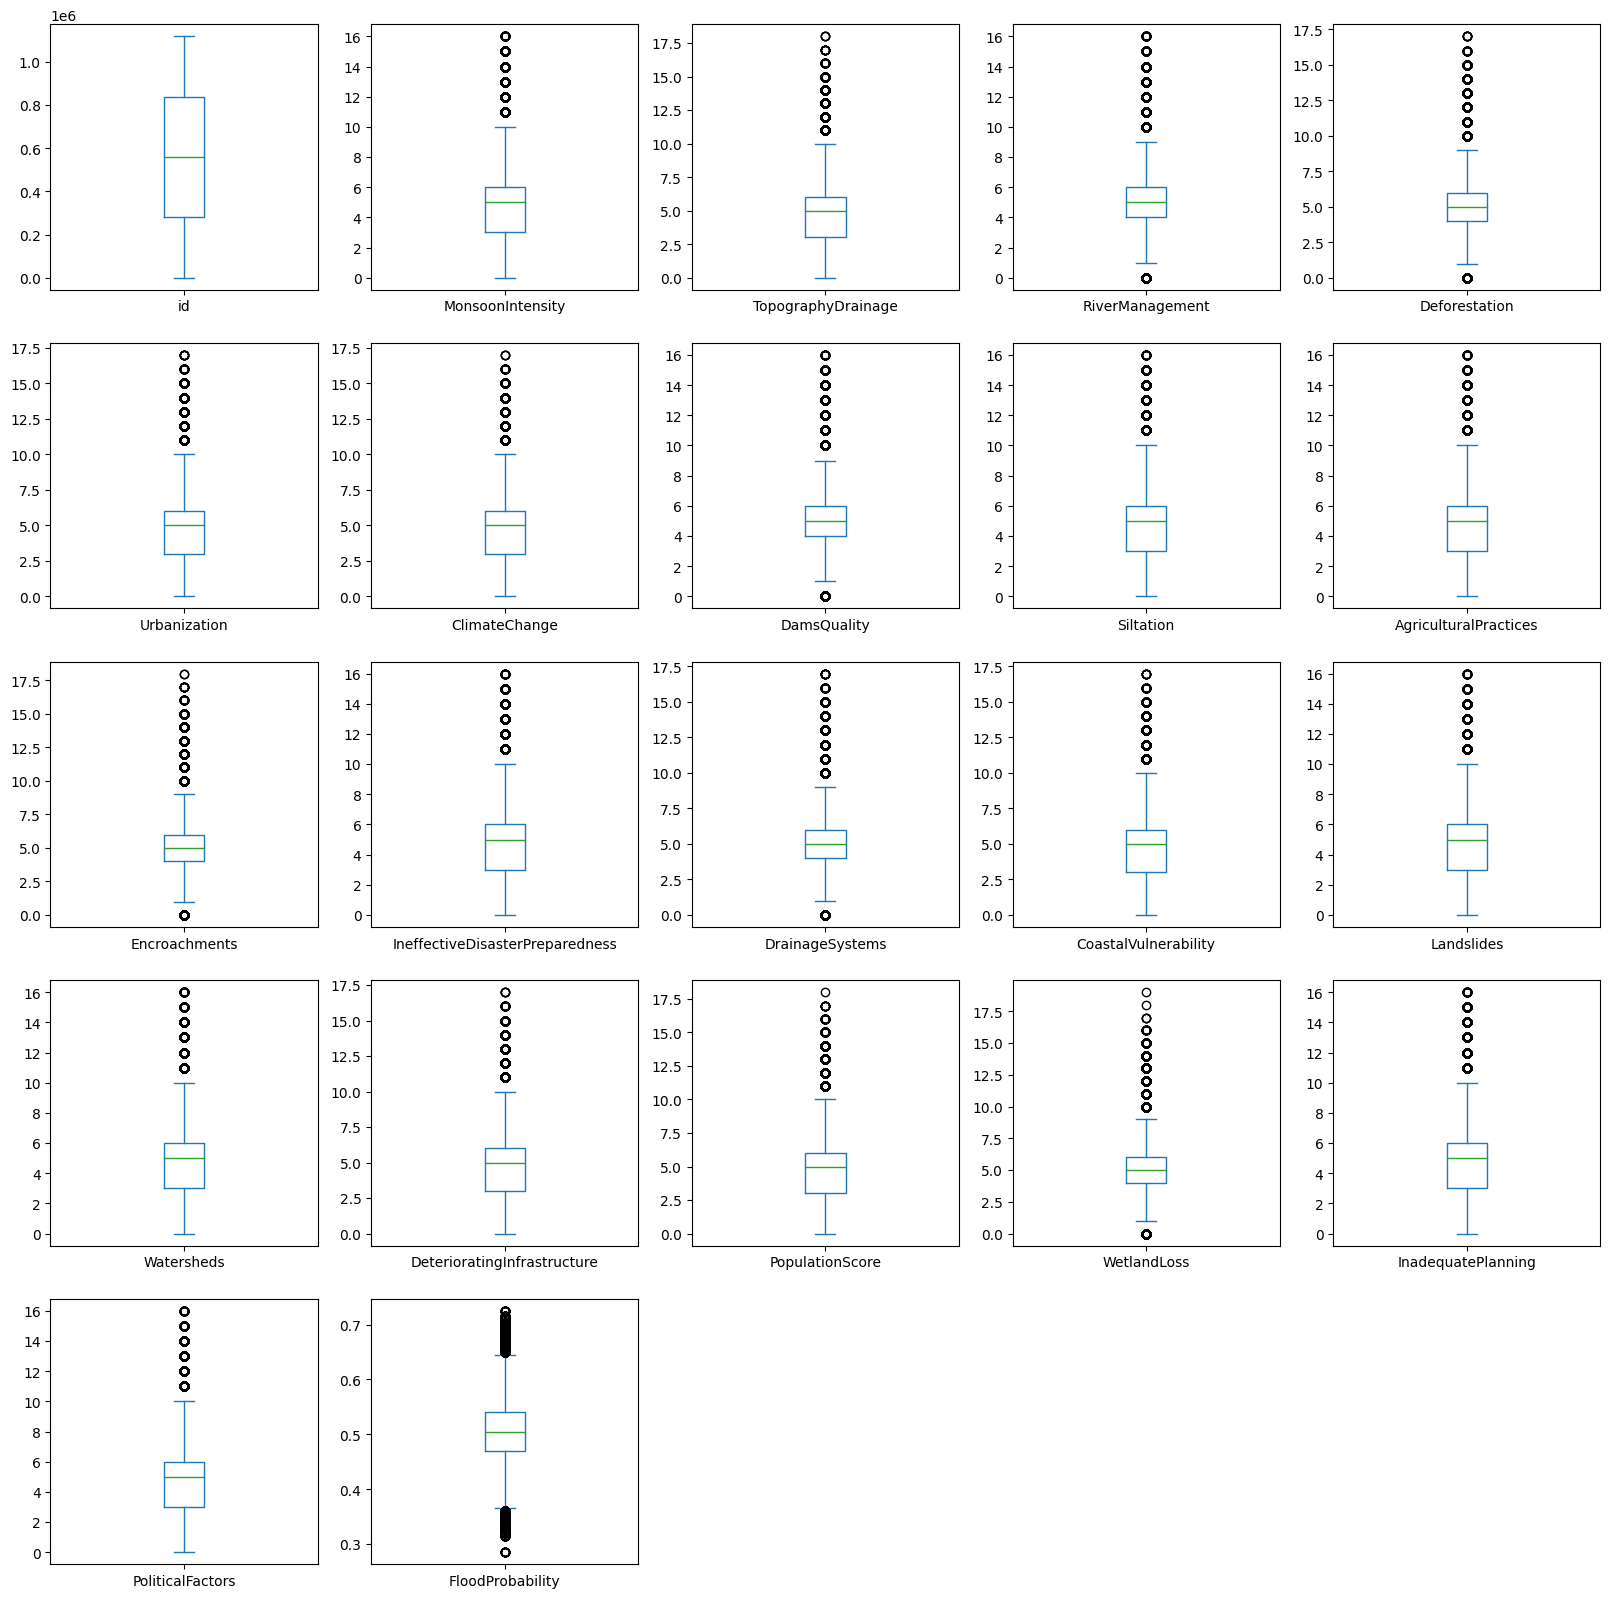

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


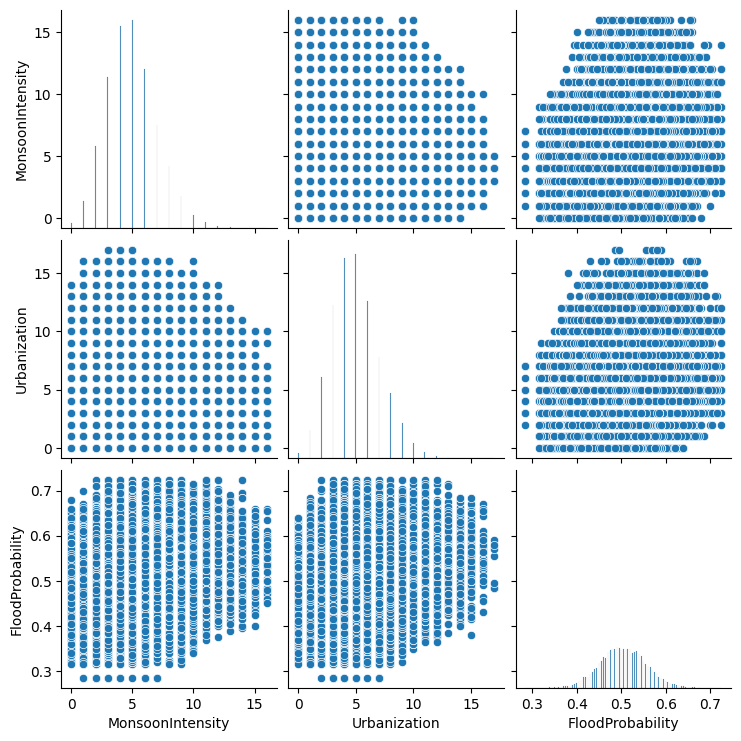

In [9]:
# Plotting histograms for all numerical data
df.hist(figsize=(20, 15), bins=20)
plt.show()

# Box plots to check for outliers
df.plot(kind='box', subplots=True, layout=(5,5), figsize=(20, 20), sharex=False, sharey=False)
plt.show()

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
# df = pd.read_csv('your_dataset.csv')  # Uncomment this line if you need to load the dataset

# Adjust the pairplot
pairplot_fig = sns.pairplot(df, diag_kind='kde', plot_kws={'alpha':0.6, 's':80, 'edgecolor':'k'}, height=3)
pairplot_fig.map_offdiag(sns.violinplot, data=df)

plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x79e0c061b130> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x79e0c061a440> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [ ]:
# Example for creating individual violin plots
plt.figure(figsize=(12, 6))
sns.violinplot(x='MonsoonIntensity', y='FloodProbability', data=df)
plt.title('Flood Probability as a function of Monsoon Intensity')
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(x='Urbanization', y='FloodProbability', data=df)
plt.title('Flood Probability as a function of Urbanization')
plt.show()

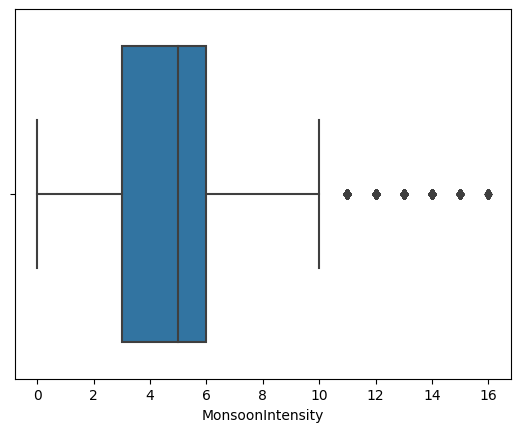

Empty DataFrame
Columns: [id, MonsoonIntensity, TopographyDrainage, RiverManagement, Deforestation, Urbanization, ClimateChange, DamsQuality, Siltation, AgriculturalPractices, Encroachments, IneffectiveDisasterPreparedness, DrainageSystems, CoastalVulnerability, Landslides, Watersheds, DeterioratingInfrastructure, PopulationScore, WetlandLoss, InadequatePlanning, PoliticalFactors, FloodProbability]
Index: []

[0 rows x 22 columns]


In [11]:
# Using box plots to visualize outliers in a specific column
sns.boxplot(x=df['MonsoonIntensity'])
plt.show()

# Or use Z-score for detecting outliers
from scipy import stats
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
outliers = (z_scores > 3).all(axis=1)
print(df[outliers])

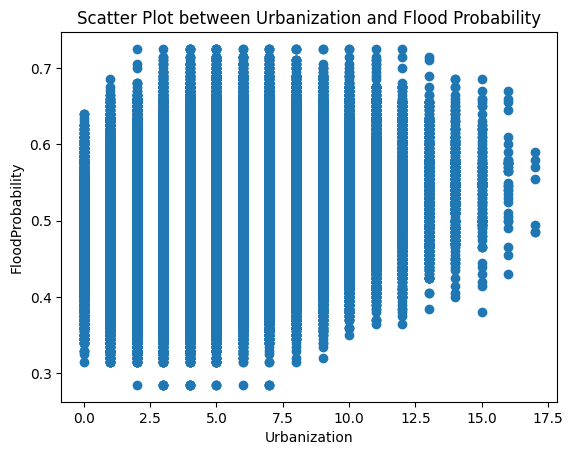

In [ ]:
# Scatter plot between two variables
plt.scatter(df['Urbanization'], df['FloodProbability'])
plt.xlabel('Urbanization')
plt.ylabel('FloodProbability')
plt.title('Scatter Plot between Urbanization and Flood Probability')
plt.show()

# Correlation matrix
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

In [7]:
#Feature Engineering

from sklearn.model_selection import train_test_split

#features
X = df.drop(columns = ['FloodProbability'])

#target variable
y = df['FloodProbability']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [7]:
# Applying Feature Engineering to Train and Test Data
train = add_features(train)

# Defining Final Feature Set
FEATURES = [col for col in train.columns if col not in NON_FEATURES]
train = train[['id'] + FEATURES + ['FloodProbability']]
test = add_features(test)
X_test = test[FEATURES]

# Separating Features and Target Variable
X_train = train.drop(['id', 'FloodProbability'], axis=1)
y_train = train['FloodProbability']

# Scaling Features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

NameError: name 'train' is not defined

In [ ]:
# Cross-Validation Setup
cv = KFold(5, shuffle=True, random_state=0)
cv_splits = cv.split(X_train, y_train)
scores = list()

# Model Training and Evaluation
model = LGBMRegressor(objective='regression', random_state=0, device='gpu', verbosity = -1,)
for train_idx, val_idx in cv_splits:
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)
    r2 = r2_score(y_val_fold, y_pred)
    scores.append(r2)
    
print(f'Mean R2 score: {np.mean(scores):.5f}')

In [21]:

# Default Hyperparameters
lgbm_params = {
        'num_leaves': 249, 
        'learning_rate': 0.015257139375608821, 
        'n_estimators': 546, 
        'subsample_for_bin': 298999, 
        'min_child_samples': 77, 
        'reg_alpha': 2.7240879929233532e-05, 
        'reg_lambda': 9.693029775370852e-10, 
        'colsample_bytree': 0.8107657422421071, 
        'subsample': 0.8727733774586144, 
        'max_depth': 10,
    }

# Model Training with Optimized Hyperparameters
cv = KFold(5, shuffle=True, random_state=0)
cv_splits = cv.split(X_train, y_train)
scores = list()
test_preds = list()
model = LGBMRegressor(**lgbm_params, objective='regression', random_state=0, device='cpu',)
for train_idx, val_idx in cv_splits:
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    model.fit(X_train_fold, y_train_fold)
    y_val_pred = model.predict(X_val_fold)
    r2 = r2_score(y_val_fold, y_val_pred)
    scores.append(r2)
    y_pred = model.predict(X_test)
    test_preds.append(y_pred)

print(f'Mean R2 score: {np.mean(scores):.5f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.718585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1631
[LightGBM] [Info] Number of data points in the train set: 894365, number of used features: 33
[LightGBM] [Info] Start training from score 0.504476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [22]:
# Creating Submission File
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e5/sample_submission.csv')
sample_submission['FloodProbability'] = np.mean(test_preds, axis=0)
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()

,id,FloodProbability
0,1117957,0.578328
1,1117958,0.455473
2,1117959,0.448603
3,1117960,0.467096
4,1117961,0.466211
